In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from models.model2 import BicycleModel
from models.model4 import FourWheelModel
from models.utils import get_csv_row_count
from models.utils import get_folder_path
from models.utils import fit_circle
from models.utils import plot_column_histograms
import time
import csv

In [12]:
##FINAL VERSION WITH FITNESS FUNCTION NOT COMPUTED EVRY TIME

np.random.seed(2)

class Particle:
    def __init__(self, position, velocity,id, dimension, commands, ref_traj):
        # Necessary for all the particles iincluding thrash one
        self.dt = 0.025
        self.commands = commands
        self.ref_traj = ref_traj
        self.N = (self.commands).shape[0]
        self.open_loop_tf = self.N*self.dt


        self.position = position
        self.velocity = velocity
        self.best_position = position.copy()
        self.dimension = dimension

        #related to vehicle model
        self.param_to_infer = 2
        self.model = None
        # T_peak and T_slope is not specified since we infer those
        self.id = id

        
        self.position_cost_value = self.compute_fitness_function()
        self.best_position_cost_value = float(self.position_cost_value)


    def update_velocity(self, inertia, cognitive_rate, social_rate, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (self.best_position - self.position)
        social_component = social_rate * r2 * (global_best_position - self.position)
        self.velocity = inertia * self.velocity + cognitive_component + social_component

    def update_position(self, lower_bounds, upper_bounds):
        
        self.position += self.velocity
        self.position = np.clip(self.position, lower_bounds, upper_bounds)
        self.position_cost_value = self.compute_fitness_function()

    def update_best_position(self):
        if self.position_cost_value < self.best_position_cost_value:
            self.best_position = self.position.copy()
            self.best_position_cost_value = self.position_cost_value
    
    def compute_fitness_function(self):
        self.generate_new_model()
        t,x = self.model.do_open_loop_sim_from_np_array(self.commands, self.ref_traj)
        kpi = self.get_kpi(x)
        return kpi
    
    def get_kpi(self, x_vect):
        
        l2_norm_position = np.linalg.norm(self.ref_traj[:20,:2] - x_vect[:20,:2], axis=1).sum()
        l2_norm_velocity = np.linalg.norm(self.ref_traj[:20,2:] - x_vect[:20,2:], axis=1).sum()

        w1 = 0.5
        w2 = 0.5
        kpi = w1*l2_norm_position+w2*l2_norm_velocity
        return kpi
    

    
    def generate_new_model(self):
        T_peak = self.position[0]
        T_slope = self.position[1]
        self.model = FourWheelModel( self.dt, self.open_loop_tf,float(T_peak), float(T_slope))

class PSO:
    def __init__(self, num_particles, max_iterations, lower_bounds, upper_bounds, dimension, commands, ref_traj):
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.dimension = dimension
        self.particles = []
        self.global_best_position = None
        self.global_best_position_cost = None

        self.commands = commands
        self.ref_traj = ref_traj


        self.particle_positions_history = []
        self.particle_fitness_history = []




    #------------------OPTIMIZATION------------------#

    def optimize(self, inertia=0.5, cognitive_rate=0.5, social_rate=0.5):
        self.initialize_particles()

        for iter in range(self.max_iterations):
            
            self.particle_positions_history.append([ particle.position for particle in self.particles])
            self.particle_fitness_history.append([particle.position_cost_value for particle in self.particles])

            for particle in self.particles:
                particle.update_velocity(inertia, cognitive_rate, social_rate, self.global_best_position)
                particle.update_position(self.lower_bounds, self.upper_bounds)
                particle.update_best_position()

            self.update_global_best_position()
            if iter%10 == 0:
                print('Iteration: ', iter)
                print('Global best position', self.global_best_position)
                print('Global best Cost', self.global_best_position_cost)

    def initialize_particles(self):
        self.particles = []
        
        print('Trajectory found, now initializing all the particles...')
        t_before = time.time()
        for i in range(self.num_particles):
            
            position = np.random.uniform(self.lower_bounds, self.upper_bounds, size=self.dimension)
            velocity = np.zeros_like(position)
            id = i
            dimension = self.dimension
            particle = Particle(position, velocity, id, dimension, commands = self.commands, ref_traj = self.ref_traj)
            self.particles.append(particle)
        t_after = time.time()
        elapsed_time = t_after-t_before
        print('All particles are initialized in: ', elapsed_time, ' Expected time for inference: ', elapsed_time*self.max_iterations)
        

        index_best_initial_particle = np.argmin([ particle.position_cost_value for particle in self.particles])
        self.global_best_position = self.particles[index_best_initial_particle].position.copy()
        self.global_best_position_cost = self.particles[index_best_initial_particle].position_cost_value

    def update_global_best_position(self):
        for particle in self.particles:
            if particle.position_cost_value < self.global_best_position_cost:
                self.global_best_position = particle.position.copy()
                self.global_best_position_cost = particle.position_cost_value


    def plot_particle_positions(self, frame):
        plt.cla()
        positions = np.array(self.particle_positions_history[frame])
        for i in range(self.dimension):
            plt.plot(positions[:, i], np.zeros_like(positions[:, i]), 'go', markersize=6)
        plt.xlabel('x')
        plt.ylim([-0.5, 0.5])

    def plot_particle_fitness_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

        # Plot histogram at the start
        ax1.hist(self.particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
        ax1.set_xlabel('Fitness')
        ax1.set_ylabel('Count')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(self.particle_fitness_history) // 2
        ax2.hist(self.particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
        ax2.set_xlabel('Fitness')
        ax2.set_ylabel('Count')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist(self.particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
        ax3.set_xlabel('Fitness')
        ax3.set_ylabel('Count')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()


    def plot_particle_history(self):
        if self.dimension == 1:
            self.particle_positions_history = np.array(self.particle_positions_history)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

            # Plot histogram at the start
            ax1.hist(self.particle_positions_history[0], bins=20, color='blue', edgecolor='black')
            ax1.set_xlabel('')
            ax1.set_ylabel('Count')
            ax1.set_title('Start of Optimization')

            # Plot histogram at the middle
            middle_index = len(self.particle_positions_history) // 2
            ax2.hist(self.particle_positions_history[middle_index], bins=20, color='green', edgecolor='black')
            ax2.set_xlabel('x')
            ax2.set_ylabel('Count')
            ax2.set_title('Middle of Optimization')

            # Plot histogram at the end
            ax3.hist(self.particle_positions_history[-1], bins=20, color='red', edgecolor='black')
            ax3.set_xlabel('x')
            ax3.set_ylabel('Count')
            ax3.set_title('End of Optimization')

            plt.tight_layout()
            plt.show()


        if self.dimension == 2:
            self.particle_positions_history = np.array(self.particle_positions_history)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
            # Plot histogram at the start
            ax1.hist2d(self.particle_positions_history[0][:, 0], self.particle_positions_history[0][:, 1], bins=20, cmap='viridis')
            ax1.set_xlabel(r'$T_{peak}$')
            ax1.set_ylabel(r'$T_{front}$')
            ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

            # Plot histogram at the middle
            middle_index = len(self.particle_positions_history) // 2
            ax2.hist2d(self.particle_positions_history[middle_index][:, 0],self.particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
            ax2.set_xlabel(r'$T_{peak}$')
            ax2.set_ylabel(r'$T_{front}$')
            ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))

            # Plot histogram at the end
            ax3.hist2d(self.particle_positions_history[-1][:, 0], self.particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
            ax3.set_xlabel(r'$T_{peak}$')
            ax3.set_ylabel(r'$T_{front}$')
            ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))

            plt.tight_layout()
            plt.show()

    def plot_particle_positions_animate(self):
        self.X, self.Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
        self.Z = self.X**2 + self.Y**2

        fig = plt.figure()
        ani = FuncAnimation(fig, self.plot_particle_positions, frames=len(self.particle_positions_history), interval=200)
        plt.show()

    def save_to_csv(self, path):
        iteration = self.max_iterations
        num_particles = self.num_particles
        particles_positions = self.particle_positions_history.reshape(-1,2)

        # Define the CSV file path
        csv_file = path

        # Write data to CSV file
        with open(csv_file, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['T_peak', 'T_front', 'Iteration', 'Particles'])
            writer.writerow([particles_positions[0, 0], particles_positions[0, 1], iteration, num_particles])
            writer.writerows(particles_positions[1:])

        print(f"Data saved to {csv_file}.")



In [13]:
class Chunk_Inferencer:
    def __init__(self, chunk_size) -> None:


        file_path = '/Users/jonas/Desktop/intergation_model/open_loop_inputs/open_loop_sim_amzsim_model.csv'
        data = np.genfromtxt(file_path, delimiter=',', skip_header=0, names=True, dtype=None)
        # Access each column by its tag
        Fx_fl = data['Fx_fl']
        Fx_fr = data['Fx_fr']
        Fx_rl = data['Fx_rl']
        Fx_rr = data['Fx_rr']
        steering_angle = data['steering_angle']

        x_ref = data['x']
        y_ref = data['y']
        yaw_ref = data['yaw']
        vx_ref = data['vx']
        vy_ref = data['vy']
        dyaw_ref = data['dyaw']

        ref_commands = np.hstack([Fx_fl.reshape(-1,1), Fx_fr.reshape(-1,1), Fx_rl.reshape(-1,1), Fx_rr.reshape(-1,1), steering_angle.reshape(-1,1)])
        ref_traj = np.hstack([x_ref.reshape(-1,1), y_ref.reshape(-1,1), yaw_ref.reshape(-1,1), vx_ref.reshape(-1,1), vy_ref.reshape(-1,1), dyaw_ref.reshape(-1,1)])

        # Initialize an empty list to store the chunks
        chunks_commands = []
        chunks_traj = []

        # Loop through the array and separate it into chunks
        for i in range(0, len(ref_commands), chunk_size):
            one_chunk_co = ref_commands[i:i+chunk_size]
            one_chunk_tra = ref_traj[i:i+chunk_size]
            
            chunks_commands.append(one_chunk_co)
            chunks_traj.append(one_chunk_tra)
        
        self.chunks_commands = chunks_commands
        self.chunks_traj = chunks_traj
        
    def do_inference_one_chunk(self, chunk_number):

        upper_bouds_2d = [1,1]
        lower_bouds_2d = [0,0]
        pso = PSO(num_particles=10, max_iterations=10, lower_bounds=lower_bouds_2d, upper_bounds=upper_bouds_2d, dimension=2, commands = self.chunks_commands[chunk_number], ref_traj = self.chunks_traj[chunk_number])
        pso.optimize()
        return pso.particle_positions_history[len(pso.particle_positions_history)-1]

    def do_inference_chunks(self):
        optimal_swarms = []
        for i in range(len(self.chunks_traj)):
            current_swarm = self.do_inference_one_chunk(i)
            optimal_swarms.append(current_swarm)
        return optimal_swarms
        


instance = Chunk_Inferencer(50)

optimal_swarms = instance.do_inference_chunks()


Trajectory found, now initializing all the particles...
All particles are initialized in:  0.19878292083740234  Expected time for inference:  1.9878292083740234
Iteration:  0
Global best position [0.4203678  0.33033482]
Global best Cost 10.608695923833242
Trajectory found, now initializing all the particles...
All particles are initialized in:  0.19586420059204102  Expected time for inference:  1.9586420059204102
Iteration:  0
Global best position [0.04312904 0.1071874 ]
Global best Cost 8.281380129768738
Trajectory found, now initializing all the particles...
All particles are initialized in:  0.19367384910583496  Expected time for inference:  1.9367384910583496
Iteration:  0
Global best position [0.69819935 0.62578862]
Global best Cost 9.748169988532183
Trajectory found, now initializing all the particles...
All particles are initialized in:  0.19387388229370117  Expected time for inference:  1.9387388229370117
Iteration:  0
Global best position [0.94079541 0.21591619]
Global best Co

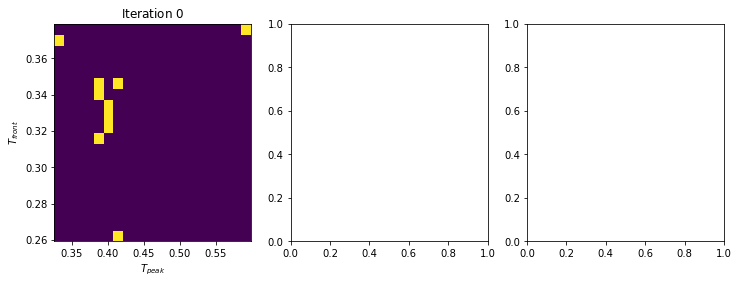

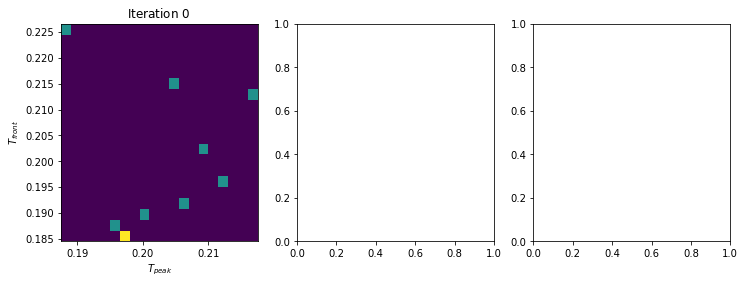

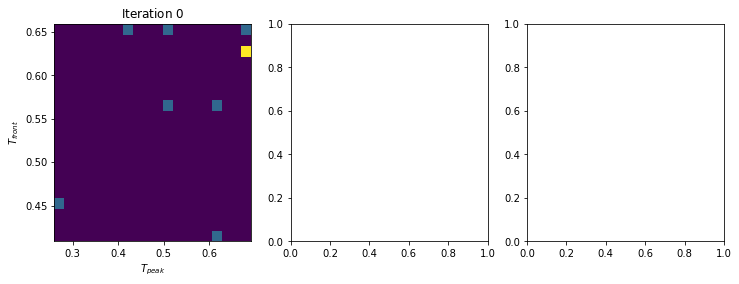

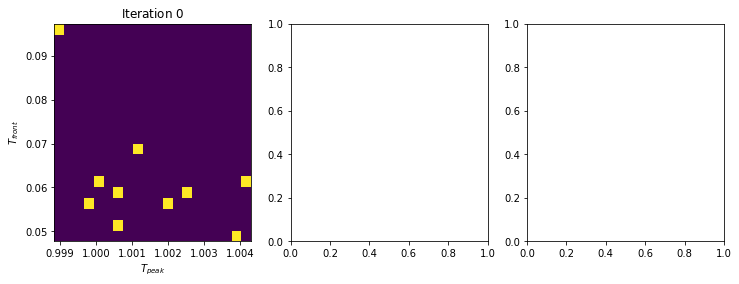

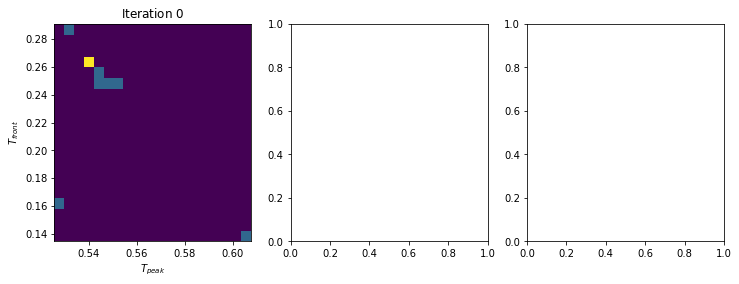

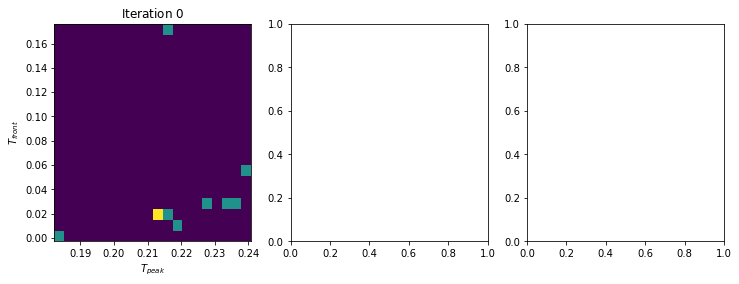

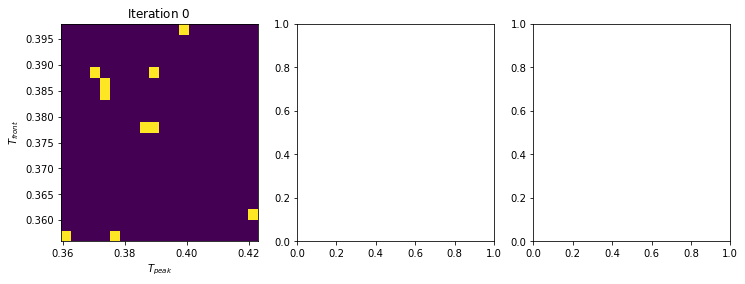

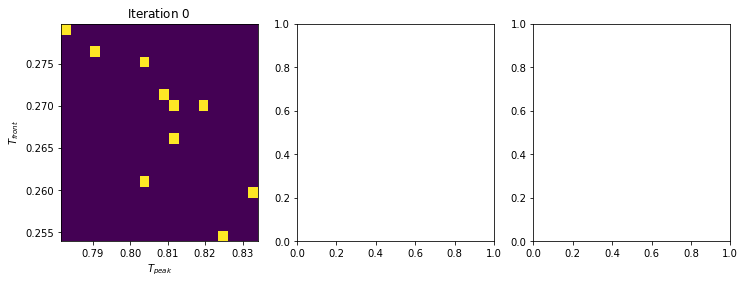

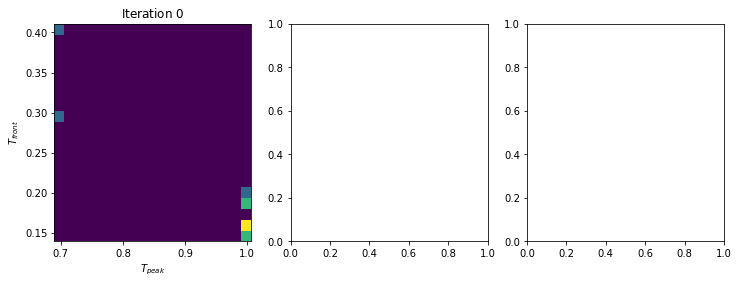

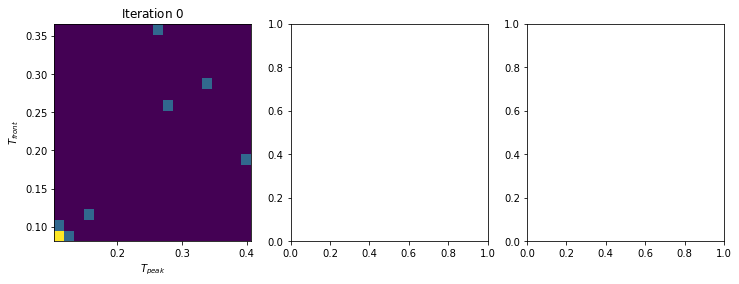

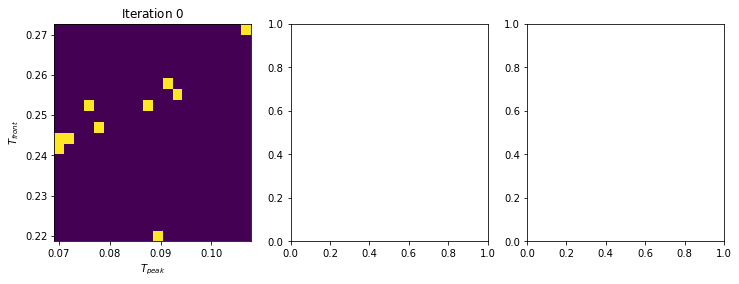

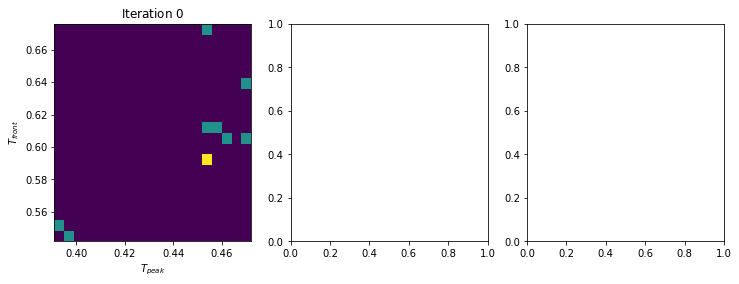

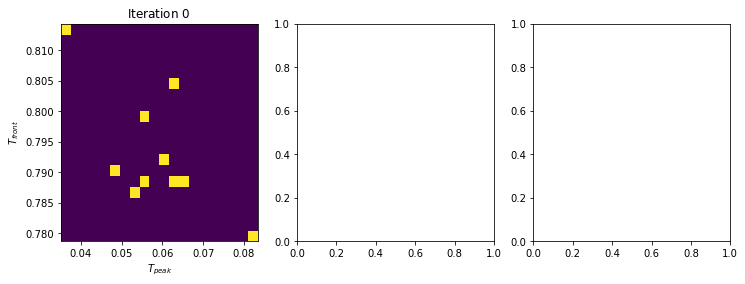

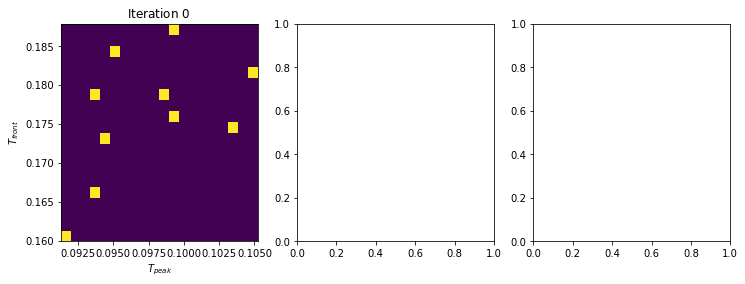

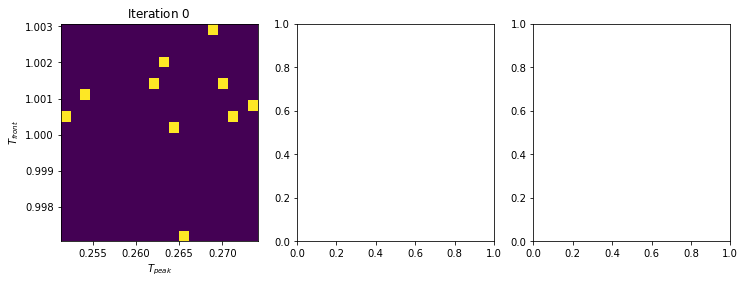

In [18]:
for i in range(len(optimal_swarms)):
    optimal_swarms[i] = np.array(optimal_swarms[i])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    # Plot histogram at the start
    ax1.hist2d(optimal_swarms[i][:, 0], optimal_swarms[i][:, 1], bins=20, cmap='viridis')
    ax1.set_xlabel(r'$T_{peak}$')
    ax1.set_ylabel(r'$T_{front}$')
    ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))



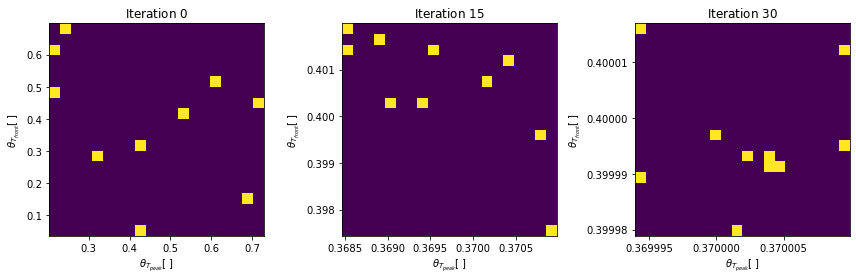

In [ ]:
# Example usage
upper_bouds_1d = 10
lower_bouds_1d = -10




pso.plot_particle_history()
pso.plot_particle_fitness_history()